<a href="https://colab.research.google.com/github/kapurm17/Self_seg_Dustbin/blob/kapurm17_patch1/WS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import random
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [4]:
!git clone https://github.com/kapurm17/Self_seg_Dustbin

Cloning into 'Self_seg_Dustbin'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 3599 (delta 5), reused 0 (delta 0), pack-reused 3579
Receiving objects: 100% (3599/3599), 42.98 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (351/351), done.


In [0]:
import shutil
shutil.rmtree('./')

OSError: ignored

In [3]:
os.listdir()

['.config', 'sample_data']

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('Self_seg_Dustbin/train/cardboard',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [7]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [9]:
data

ImageDataBunch;

Train: LabelList (1257 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (628 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (632 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [10]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


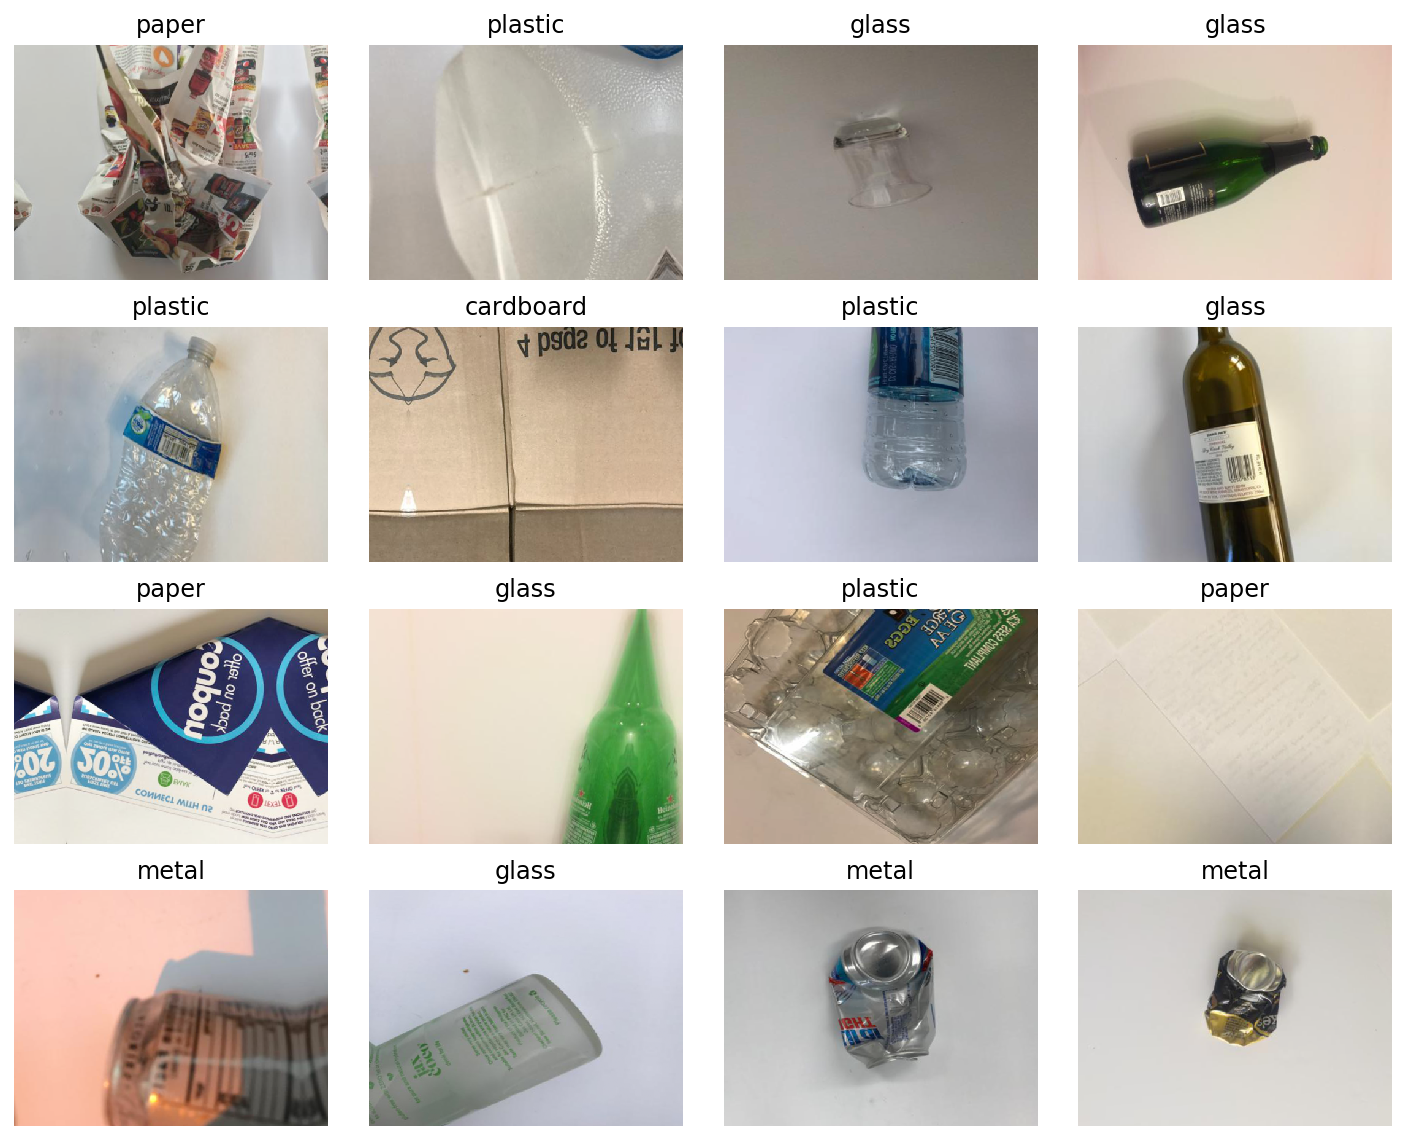

In [11]:
data.show_batch(rows=4,figsize=(10,8))

In [12]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 25.5MB/s]


In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


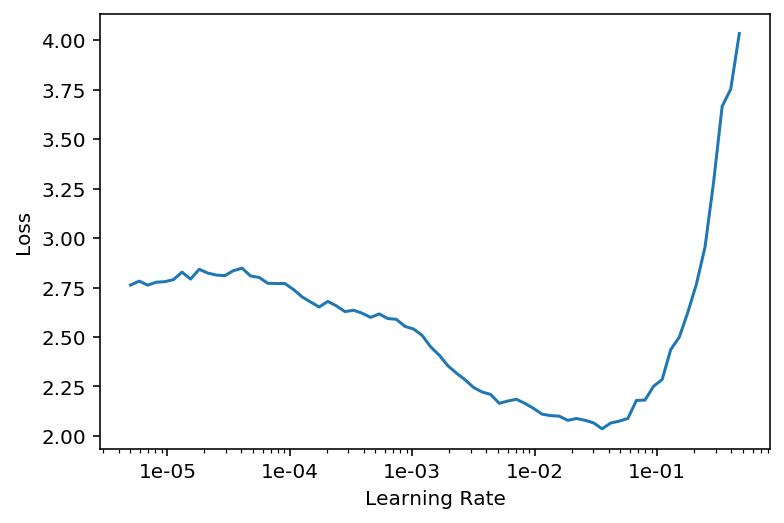

In [0]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1,max_lr=5.13e-03)


epoch,train_loss,valid_loss,error_rate,time
0,1.363024,0.661590,0.202229,24:16


In [0]:
#os.listdir('./Self_seg_Dustbin/')

['README.md', '.git', 'cnn_model.ipynb', 'WS_project.ipynb', 'train']

In [0]:
learn.path=Path("")

In [22]:
learn.path 

PosixPath('.')

In [0]:
learn.export("mymodel.pkl")

In [0]:
learn.save("weights.h5")

In [15]:
from google.colab import drive
drive.mount("/content/gdrive/")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#os.chdir('./My Drive')

In [0]:
!ls /content/gdrive/My Drive/

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/': No such file or directory


In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(learn.state_dict(), path)

AttributeError: ignored

In [0]:

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

     |████████████████████████████████| 91.1MB 1.3MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#os.listdir()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
learn.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

FileNotFoundError: ignored

In [0]:
learn.save('model.json')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

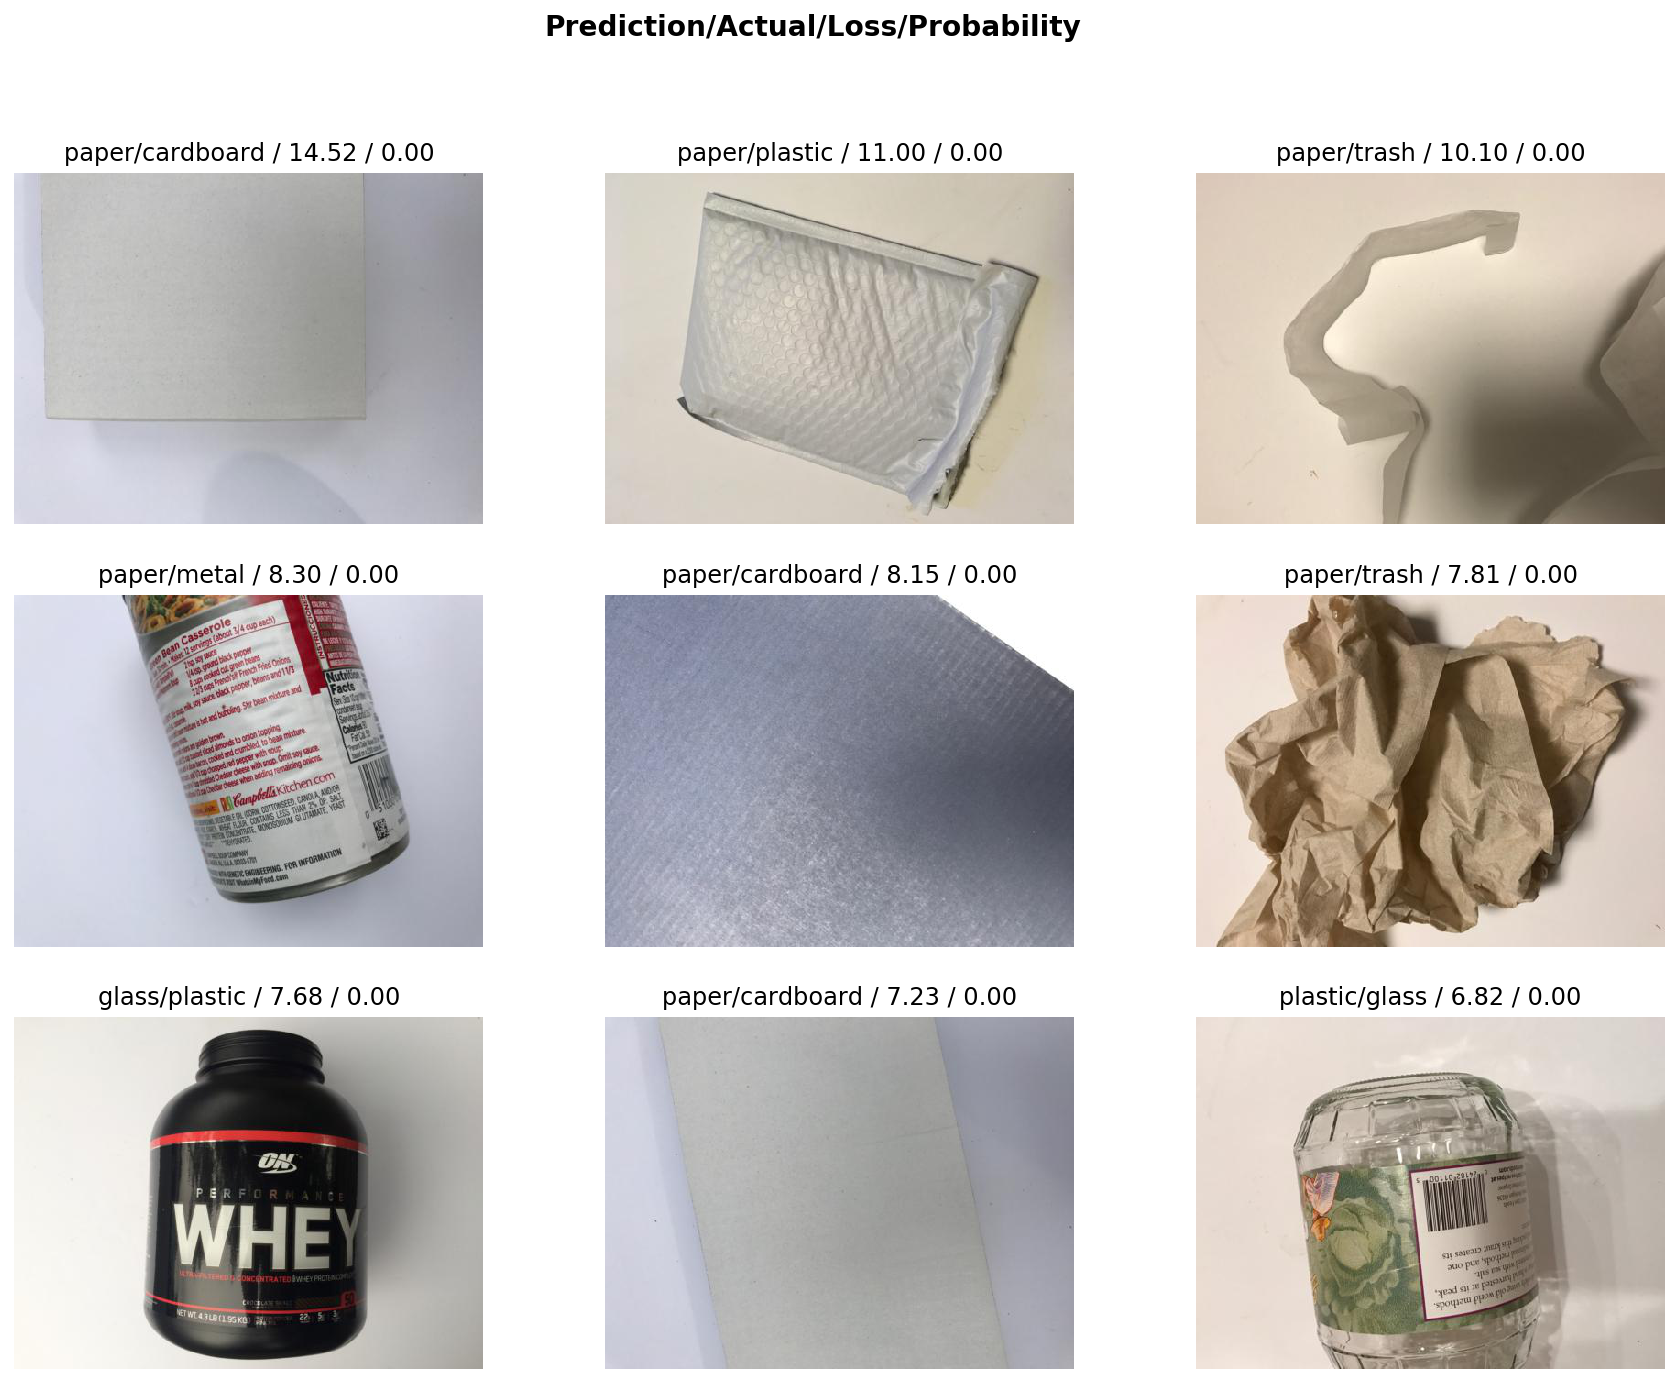

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

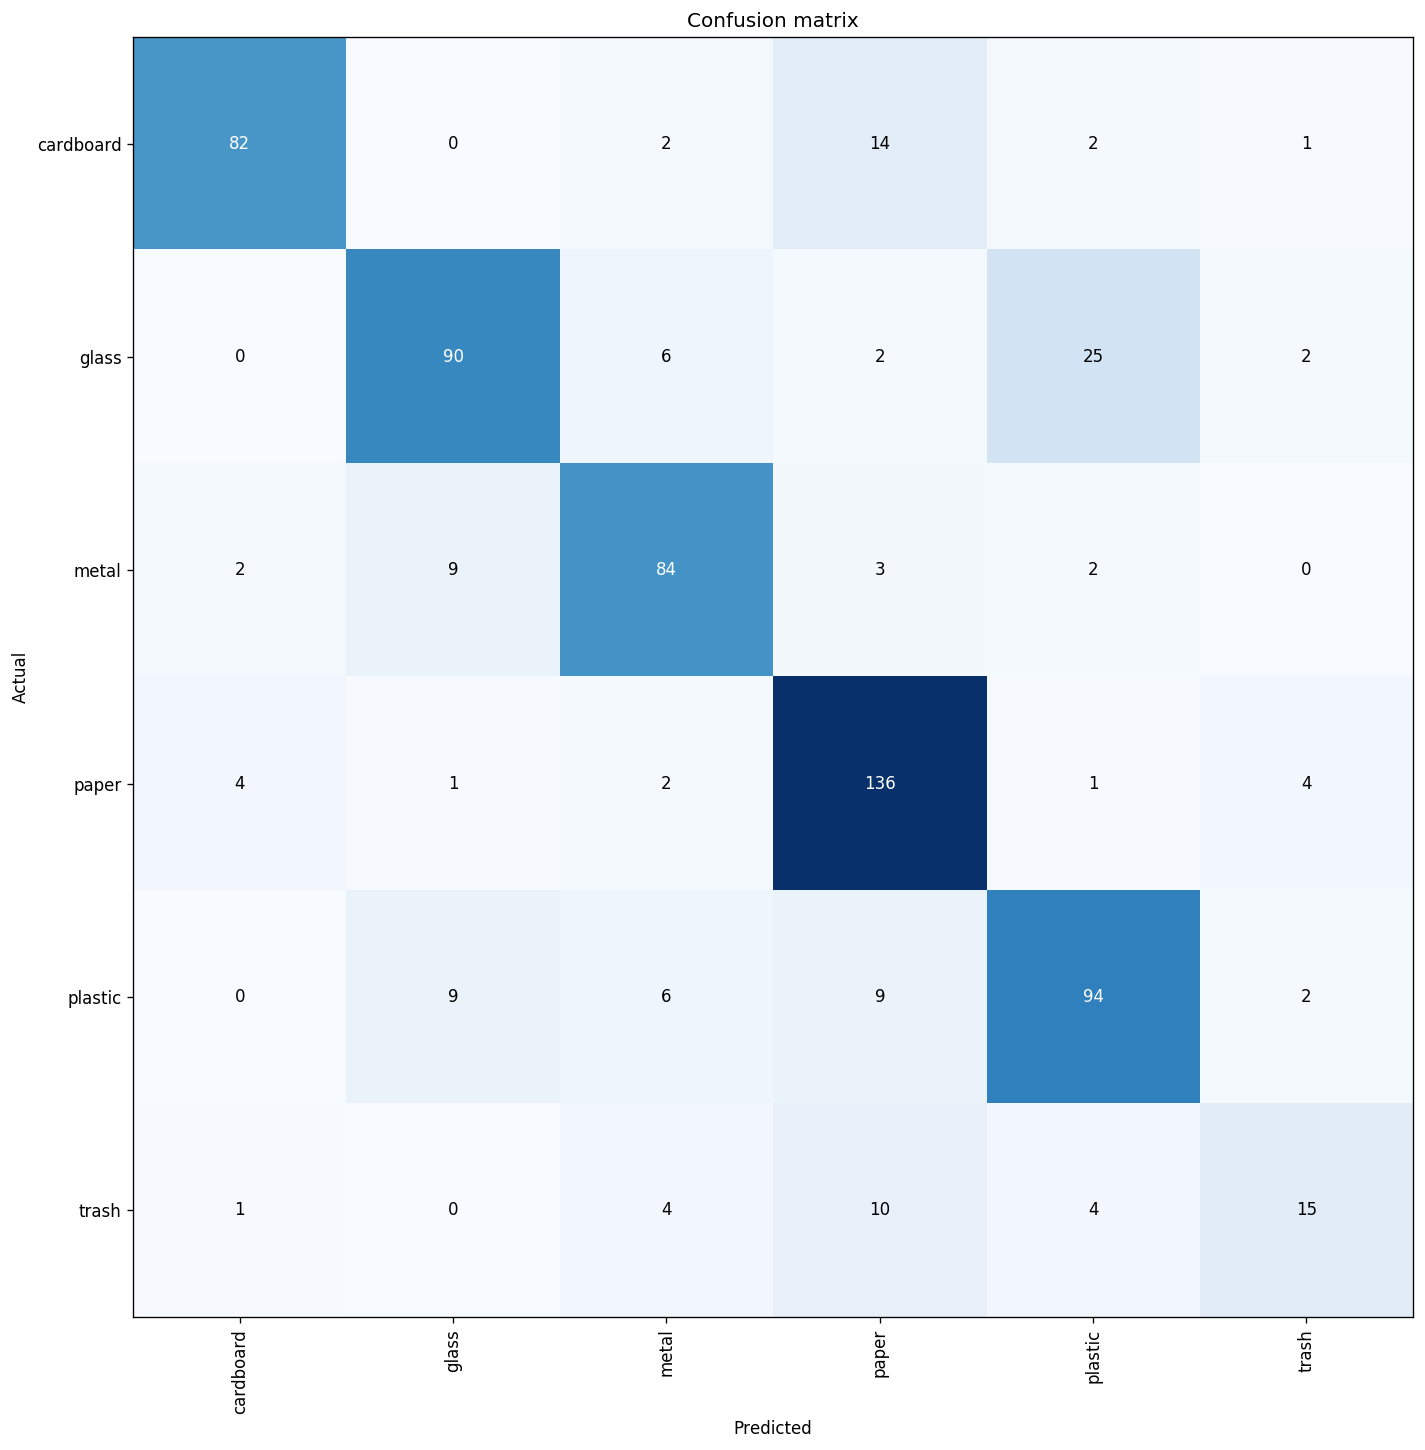

In [41]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 25),
 ('cardboard', 'paper', 14),
 ('trash', 'paper', 10),
 ('metal', 'glass', 9),
 ('plastic', 'glass', 9),
 ('plastic', 'paper', 9),
 ('glass', 'metal', 6),
 ('plastic', 'metal', 6),
 ('paper', 'cardboard', 4),
 ('paper', 'trash', 4),
 ('trash', 'metal', 4),
 ('trash', 'plastic', 4),
 ('metal', 'paper', 3),
 ('cardboard', 'metal', 2),
 ('cardboard', 'plastic', 2),
 ('glass', 'paper', 2),
 ('glass', 'trash', 2),
 ('metal', 'cardboard', 2),
 ('metal', 'plastic', 2),
 ('paper', 'metal', 2),
 ('plastic', 'trash', 2)]

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [44]:
print(preds[0].shape)
preds[0]

torch.Size([632, 6])


tensor([[3.9460e-04, 7.5406e-05, 3.9333e-02, 8.1072e-01, 3.1709e-04, 1.4916e-01],
        [1.3431e-06, 9.9433e-01, 4.5215e-04, 3.9520e-08, 5.2119e-03, 8.6127e-06],
        [9.9992e-01, 5.6515e-09, 2.4960e-08, 7.3512e-05, 8.7381e-09, 1.8400e-06],
        ...,
        [9.4605e-04, 8.2451e-02, 2.0596e-02, 9.1666e-03, 8.8216e-01, 4.6767e-03],
        [4.7766e-05, 2.8307e-04, 9.9833e-01, 1.4627e-05, 6.0073e-04, 7.1989e-04],
        [6.9004e-05, 1.1349e-01, 8.8798e-03, 1.0072e-01, 7.7678e-01, 5.9496e-05]])

In [45]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [0]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [48]:
yhat

['paper',
 'glass',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'cardboard',
 'metal',
 'glass',
 'plastic',
 'cardboard',
 'metal',
 'glass',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'plastic',
 'trash',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'cardboard',
 'plastic',
 'plastic',
 'cardboard',
 'paper',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'plastic',
 'trash',
 'plastic',
 'metal',
 'metal',
 'glass',
 'plastic',
 'cardboard',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'trash',
 'paper',
 'glass',
 'glass',
 'trash',
 'cardboard',
 'plastic',
 'cardboard',
 'glass',
 'paper',
 'glass',
 'metal',
 'glass',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'trash',
 'cardboard',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'plastic',
 'trash',
 'trash'

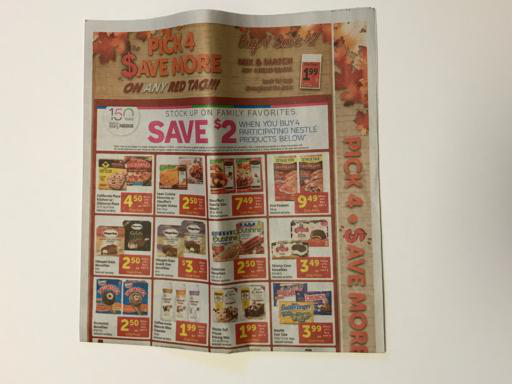

In [49]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [51]:
## predicted values
print(yhat[0:10])
## actual values
print(y[0:10])
s=0
for i in range(632):
  if y[i]==yhat[i]:
    s+=1 
print(s)

['paper', 'glass', 'cardboard', 'glass', 'plastic', 'glass', 'cardboard', 'metal', 'glass', 'plastic']
['paper', 'glass', 'cardboard', 'glass', 'plastic', 'glass', 'cardboard', 'metal', 'metal', 'glass']
497


In [52]:
learn.data.test_ds[0][1]

EmptyLabel 

In [53]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 85   1   1  12   0   2]
 [  0  85  15   0  25   1]
 [  1  12  75   4   7   1]
 [  2   0   4 139   2   2]
 [  1  14   4   4  97   1]
 [  3   0   3   7   6  16]]


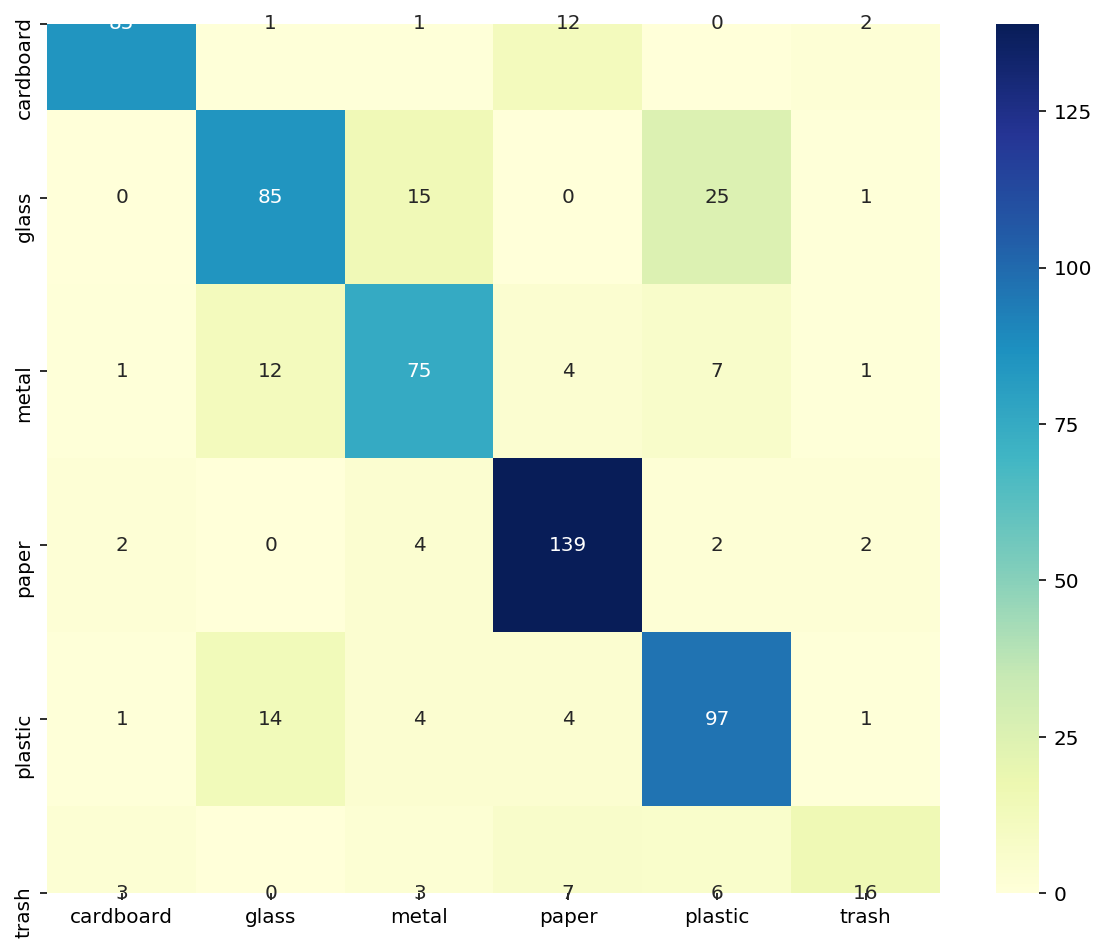

In [54]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [56]:
accuracy = correct/sum(sum(cm))
accuracy

0.7863924050632911

In [0]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')